# NOTE:
#### In this code,
#### -> We consider the peak demand of a day.
#### -> Predict the peak demand of a day.
#### -> we include X[peak_temp, avg_temp] + [class]
#### -> Here we train the model using both 2022 data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import os
import copy
import glob
%matplotlib widget

In [ ]:
demand_df_path = r".\Demand_data_with_class_2022_2023.csv"

In [ ]:
demand_df_shortImputed = pd.read_csv(demand_df_path, parse_dates=["Unnamed: 0"], index_col=0)
demand_df_shortImputed.index = pd.to_datetime(demand_df_shortImputed.index)
demand_df_used = demand_df_shortImputed.copy()
demand_df_used

,Power,Temperature,Class
2022-01-01 00:00:00,NaN,13.40,Vacation
2022-01-01 01:00:00,NaN,12.90,Vacation
2022-01-01 02:00:00,NaN,12.50,Vacation
2022-01-01 03:00:00,NaN,12.00,Vacation
2022-01-01 04:00:00,NaN,13.00,Vacation
...,...,...,...
2023-12-31 19:00:00,3.00,16.11,Vacation
2023-12-31 20:00:00,3.30,16.11,Vacation
2023-12-31 21:00:00,3.25,16.11,Vacation
2023-12-31 22:00:00,NaN,16.11,Vacation


In [4]:
df = demand_df_used.copy()
df.index = pd.to_datetime(df.index)

hour_count = df["Power"].resample("D").count()

daily_demand_df = pd.DataFrame(index=hour_count.index)

daily_demand_df["PeakPower"] = df["Power"].resample("D").max()
daily_demand_df["PeakTemp"]  = df["Temperature"].resample("D").max()
daily_demand_df["AvgTemp"]   = df["Temperature"].resample("D").mean()

# Dominant class of the day
daily_demand_df["Class"] = (
    df["Class"]
    .resample("D")
    .agg(lambda x: x.mode().iloc[0])
)

daily_demand_df

,PeakPower,PeakTemp,AvgTemp,Class
2022-01-01,NaN,24.20,16.966667,Vacation
2022-01-02,NaN,25.00,17.266667,Weekend
2022-01-03,NaN,25.00,17.700000,Working_Days
2022-01-04,NaN,24.40,17.800000,Working_Days
2022-01-05,NaN,25.40,17.900000,Working_Days
...,...,...,...,...
2023-12-27,3.3,27.22,20.138750,Vacation
2023-12-28,3.1,27.22,20.069375,Vacation
2023-12-29,3.8,27.22,19.606250,Vacation
2023-12-30,3.1,26.11,19.467500,Vacation


In [5]:
daily_demand_df["dayofweek"] = daily_demand_df.index.dayofweek
daily_demand_df["month"]     = daily_demand_df.index.month
daily_demand_df

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month
2022-01-01,NaN,24.20,16.966667,Vacation,5,1
2022-01-02,NaN,25.00,17.266667,Weekend,6,1
2022-01-03,NaN,25.00,17.700000,Working_Days,0,1
2022-01-04,NaN,24.40,17.800000,Working_Days,1,1
2022-01-05,NaN,25.40,17.900000,Working_Days,2,1
...,...,...,...,...,...,...
2023-12-27,3.3,27.22,20.138750,Vacation,2,12
2023-12-28,3.1,27.22,20.069375,Vacation,3,12
2023-12-29,3.8,27.22,19.606250,Vacation,4,12
2023-12-30,3.1,26.11,19.467500,Vacation,5,12


### Splitting 2022

In [6]:
daily_demand_df_2022 = daily_demand_df["2022-01-01":"2022-12-31"]
daily_demand_df_2022

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month
2022-01-01,NaN,24.2,16.966667,Vacation,5,1
2022-01-02,NaN,25.0,17.266667,Weekend,6,1
2022-01-03,NaN,25.0,17.700000,Working_Days,0,1
2022-01-04,NaN,24.4,17.800000,Working_Days,1,1
2022-01-05,NaN,25.4,17.900000,Working_Days,2,1
...,...,...,...,...,...,...
2022-12-27,2.200000,24.8,17.033333,Vacation,1,12
2022-12-28,3.800000,25.0,16.825000,Vacation,2,12
2022-12-29,3.800000,21.0,16.879167,Vacation,3,12
2022-12-30,3.144264,21.0,16.675000,Vacation,4,12


In [7]:
daily_demand_df_2022.isna().sum()

PeakPower    109
PeakTemp       0
AvgTemp        0
Class          0
dayofweek      0
month          0
dtype: int64

In [8]:
daily_demand_df_used_2022 = daily_demand_df_2022.copy()
daily_demand_df_used_2022 = daily_demand_df_used_2022.dropna(subset=["PeakPower"])  # contains no NaN
daily_demand_df_used_2022.PeakPower.isna().sum()

np.int64(0)

# Training using 2022 data

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

daily_feature_cols = ["PeakTemp", "AvgTemp", "dayofweek", "month"]

df_model = daily_demand_df_used_2022.copy()

# One-hot encode Class
df_model = pd.get_dummies(df_model, columns=["Class"], drop_first=True)

feature_cols = ["PeakTemp", "AvgTemp", "dayofweek", "month"] + \
               [c for c in df_model.columns if c.startswith("Class_")]

X = df_model[feature_cols]
y = df_model["PeakPower"]

model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.03,
    max_iter=600,
    min_samples_leaf=20,
    random_state=42
)

model.fit(X, y)



,loss,'squared_error'
,quantile,None
,learning_rate,0.03
,max_iter,600
,max_leaf_nodes,31
,max_depth,8
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [30]:
feature_cols

['PeakTemp',
 'AvgTemp',
 'dayofweek',
 'month',
 'Class_Long_Holiday',
 'Class_Short_Holiday',
 'Class_Vacation',
 'Class_Weekend',
 'Class_Working_Days']

# Prediction for 2022

In [ ]:
from sklearn.metrics import r2_score

daily_demand_df_2022 = daily_demand_df_2022.copy()

df_pred = daily_demand_df_2022.copy()

df_pred = pd.get_dummies(df_pred, columns=["Class"], drop_first=True)

for col in feature_cols:
    if col not in df_pred.columns:
        df_pred[col] = 0

df_pred = df_pred[feature_cols]

daily_demand_df_2022["PredictedPower"] = model.predict(df_pred)

### R2 score

In [11]:
valid_idx = daily_demand_df_2022["PeakPower"].notna()

df_valid = daily_demand_df_2022.loc[valid_idx]

test_df = df_valid.sample(frac=0.10, random_state=None)

y_true = test_df["PeakPower"]
y_pred = test_df["PredictedPower"]

r2 = r2_score(y_true, y_pred)

print(f"Random 10% Test R²: {r2:.3f}")


Random 10% Test R²: 0.943


In [12]:
daily_demand_df_2022

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month,PredictedPower
2022-01-01,NaN,24.2,16.966667,Vacation,5,1,3.137092
2022-01-02,NaN,25.0,17.266667,Weekend,6,1,3.333161
2022-01-03,NaN,25.0,17.700000,Working_Days,0,1,2.971714
2022-01-04,NaN,24.4,17.800000,Working_Days,1,1,2.977246
2022-01-05,NaN,25.4,17.900000,Working_Days,2,1,3.331128
...,...,...,...,...,...,...,...
2022-12-27,2.200000,24.8,17.033333,Vacation,1,12,3.375996
2022-12-28,3.800000,25.0,16.825000,Vacation,2,12,3.897703
2022-12-29,3.800000,21.0,16.879167,Vacation,3,12,3.896946
2022-12-30,3.144264,21.0,16.675000,Vacation,4,12,3.529196


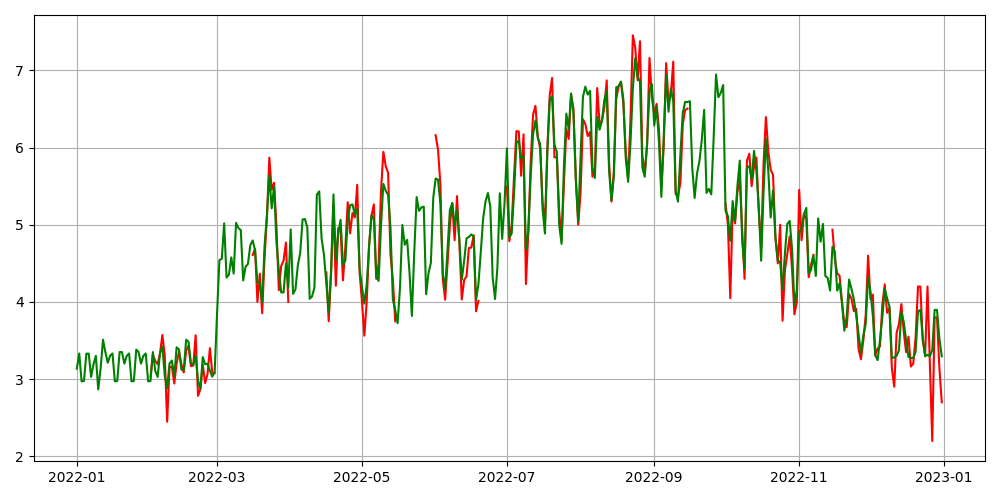

In [13]:
plt.figure(figsize=(10,5))
plt.plot(daily_demand_df_2022.index, daily_demand_df_2022.PeakPower, color = "r")
plt.plot(daily_demand_df_2022.index, daily_demand_df_2022.PredictedPower, color = "g")
plt.grid()
plt.tight_layout()
plt.show()


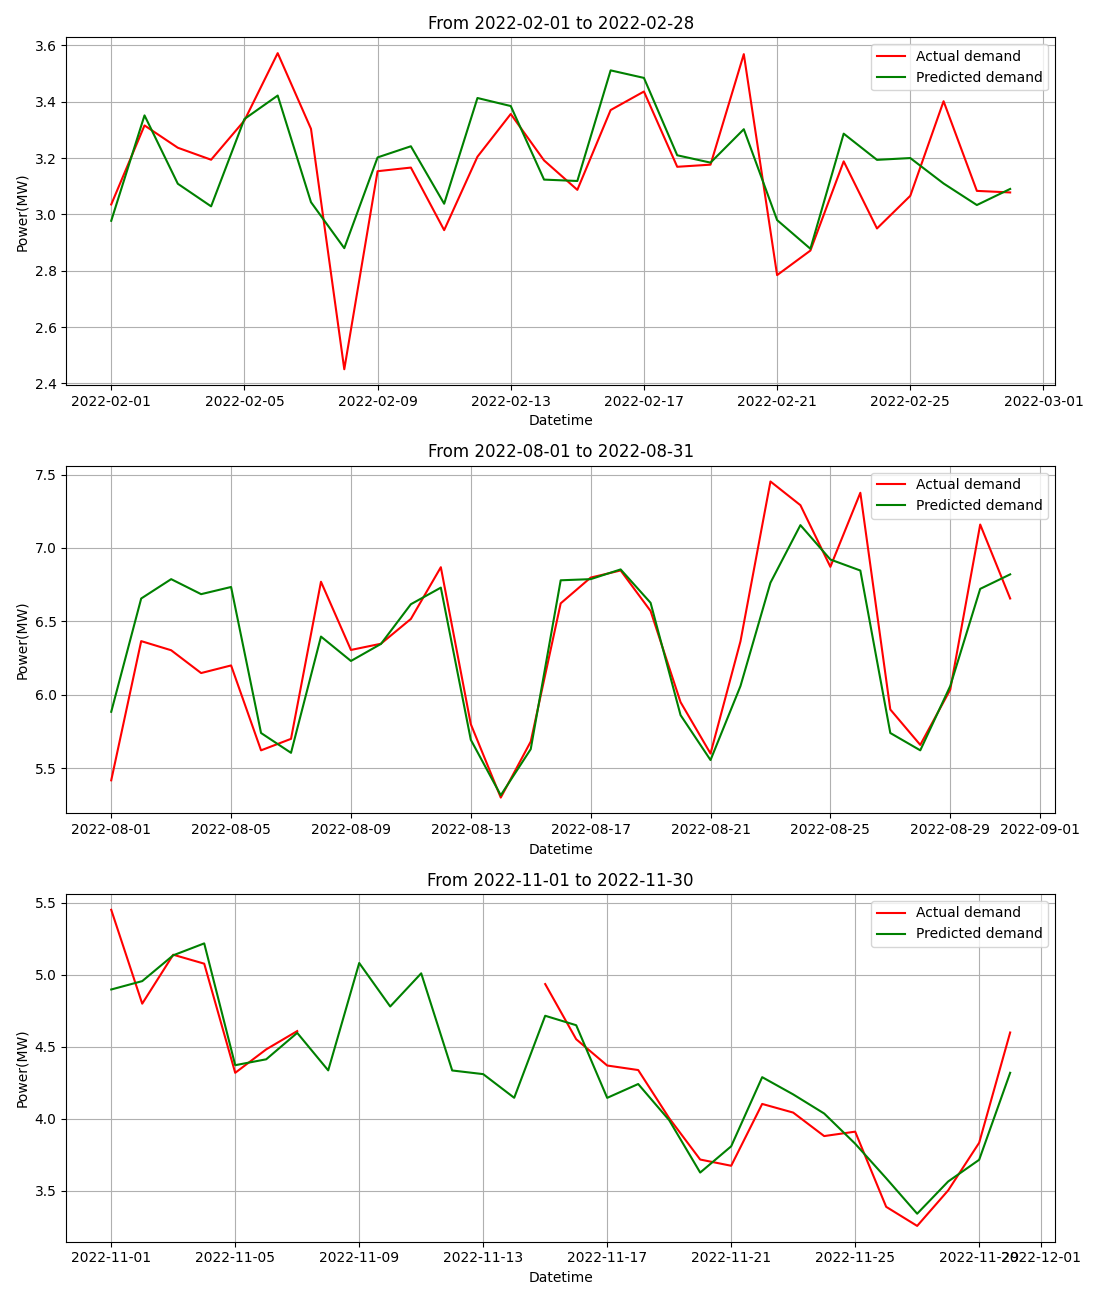

In [14]:
fig, axes = plt.subplots(3, 1,figsize=(11, 13))
ax1, ax2, ax3 = axes.flatten()

ax1.plot(daily_demand_df_2022.loc["2022-02-01": "2022-02-28"].index, daily_demand_df_2022.loc["2022-02-01": "2022-02-28", "PeakPower"], label="Actual demand", color="red")
ax1.plot(daily_demand_df_2022.loc["2022-02-01": "2022-02-28"].index, daily_demand_df_2022.loc["2022-02-01": "2022-02-28", "PredictedPower"], label="Predicted demand", color="green")
ax1.grid()
ax1.legend()
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.set_title("From 2022-02-01 to 2022-02-28")

ax2.plot(daily_demand_df_2022.loc["2022-08-01": "2022-08-31"].index, daily_demand_df_2022.loc["2022-08-01": "2022-08-31", "PeakPower"], label="Actual demand", color="red")
ax2.plot(daily_demand_df_2022.loc["2022-08-01": "2022-08-31"].index, daily_demand_df_2022.loc["2022-08-01": "2022-08-31", "PredictedPower"], label="Predicted demand", color="green")
ax2.grid()
ax2.legend()
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.set_title("From 2022-08-01 to 2022-08-31")

ax3.plot(daily_demand_df_2022.loc["2022-11-01": "2022-11-30"].index, daily_demand_df_2022.loc["2022-11-01": "2022-11-30", "PeakPower"], label="Actual demand", color="red")
ax3.plot(daily_demand_df_2022.loc["2022-11-01": "2022-11-30"].index, daily_demand_df_2022.loc["2022-11-01": "2022-11-30", "PredictedPower"], label="Predicted demand", color="green")
ax3.grid()
ax3.legend()
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.set_title("From 2022-11-01 to 2022-11-30")

plt.tight_layout()
plt.show()

In [15]:
daily_demand_df_2022["ImputedPower"] = daily_demand_df_2022.PeakPower.values
isMissing2022 = daily_demand_df_2022["ImputedPower"].isna()
daily_demand_df_2022.loc[isMissing2022, "ImputedPower"] = daily_demand_df_2022["PredictedPower"]
daily_demand_df_2022

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month,PredictedPower,ImputedPower
2022-01-01,NaN,24.2,16.966667,Vacation,5,1,3.137092,3.137092
2022-01-02,NaN,25.0,17.266667,Weekend,6,1,3.333161,3.333161
2022-01-03,NaN,25.0,17.700000,Working_Days,0,1,2.971714,2.971714
2022-01-04,NaN,24.4,17.800000,Working_Days,1,1,2.977246,2.977246
2022-01-05,NaN,25.4,17.900000,Working_Days,2,1,3.331128,3.331128
...,...,...,...,...,...,...,...,...
2022-12-27,2.200000,24.8,17.033333,Vacation,1,12,3.375996,2.200000
2022-12-28,3.800000,25.0,16.825000,Vacation,2,12,3.897703,3.800000
2022-12-29,3.800000,21.0,16.879167,Vacation,3,12,3.896946,3.800000
2022-12-30,3.144264,21.0,16.675000,Vacation,4,12,3.529196,3.144264


In [16]:
print("Actual Peak Power for 2022 = ", daily_demand_df_2022.max().PeakPower, "\nPredicted Peak Power for 2022 = ", daily_demand_df_2022.max().PredictedPower)
print("Actual Power date = ", daily_demand_df_2022.PeakPower.idxmax(), "\nPredicted Power date = ", daily_demand_df_2022.PredictedPower.idxmax())

Actual Peak Power for 2022 =  7.452957400000001 
Predicted Peak Power for 2022 =  7.155634064260718
Actual Power date =  2022-08-23 00:00:00 
Predicted Power date =  2022-08-24 00:00:00


In [17]:
from sklearn.metrics import mean_absolute_error

mask_2022 = daily_demand_df_2022["PeakPower"].notna() & daily_demand_df_2022["PredictedPower"].notna()

y_true_2022 = daily_demand_df_2022.loc[mask_2022, "PeakPower"].values
y_pred_2022 = daily_demand_df_2022.loc[mask_2022, "PredictedPower"].values

mae_2022_model3 = mean_absolute_error(y_true_2022, y_pred_2022)
print("Model 3 — MAE for 2022 (Daily Peak):", mae_2022_model3, "MW")


Model 3 — MAE for 2022 (Daily Peak): 0.18207907051827305 MW


In [18]:
mask_2022_m3 = (
    daily_demand_df_2022["PeakPower"].notna() &
    daily_demand_df_2022["PredictedPower"].notna() &
    (daily_demand_df_2022["PeakPower"] > 0)
)

y_true_2022_m3 = daily_demand_df_2022.loc[mask_2022_m3, "PeakPower"].values
y_pred_2022_m3 = daily_demand_df_2022.loc[mask_2022_m3, "PredictedPower"].values

mape_2022_model3 = np.mean(np.abs((y_true_2022_m3 - y_pred_2022_m3) / y_true_2022_m3)) * 100
print("Model 3 — MAPE for 2022:", round(mape_2022_model3, 2), "%")

Model 3 — MAPE for 2022: 4.04 %


# retraining the model with imputed 2022 data for prediction of 2023

In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor

daily_feature_cols = ["PeakTemp", "AvgTemp", "dayofweek", "month"]

df_model = daily_demand_df_2022

# One-hot encode Class
df_model = pd.get_dummies(df_model, columns=["Class"], drop_first=True)

feature_cols = ["PeakTemp", "AvgTemp", "dayofweek", "month"] + \
               [c for c in df_model.columns if c.startswith("Class_")]

X = df_model[feature_cols]
y = df_model["ImputedPower"]

model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.03,
    max_iter=600,
    min_samples_leaf=20,
    random_state=42
)

model.fit(X, y)

,loss,'squared_error'
,quantile,None
,learning_rate,0.03
,max_iter,600
,max_leaf_nodes,31
,max_depth,8
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


# Prediction for 2023

In [20]:
daily_demand_df_2023 = daily_demand_df.loc["2023-01-01":"2023-12-31"].copy()
daily_demand_df_2023

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month
2023-01-01,3.289532,22.78,16.562500,Vacation,6,1
2023-01-02,3.229958,22.78,16.458333,Vacation,0,1
2023-01-03,3.488561,23.89,16.677708,Vacation,1,1
2023-01-04,3.800027,23.89,17.013542,Working_Days,2,1
2023-01-05,3.487847,25.00,17.477083,Working_Days,3,1
...,...,...,...,...,...,...
2023-12-27,3.300000,27.22,20.138750,Vacation,2,12
2023-12-28,3.100000,27.22,20.069375,Vacation,3,12
2023-12-29,3.800000,27.22,19.606250,Vacation,4,12
2023-12-30,3.100000,26.11,19.467500,Vacation,5,12


In [21]:
daily_demand_df_2023 = daily_demand_df_2023.copy()

df_pred_2023 = pd.get_dummies(daily_demand_df_2023, columns=["Class"], drop_first=True)

for col in feature_cols:
    if col not in df_pred_2023.columns:
        df_pred_2023[col] = 0

df_pred_2023 = df_pred_2023[feature_cols]

daily_demand_df_2023["PredictedPeakPower"] = model.predict(df_pred_2023)


## Evaluation for 2023

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error

valid = daily_demand_df_2023.dropna(subset=["PeakPower", "PredictedPeakPower"])

r2  = r2_score(valid["PeakPower"], valid["PredictedPeakPower"])
mae = mean_absolute_error(valid["PeakPower"], valid["PredictedPeakPower"])

print(f"Daily Peak R²  : {r2:.3f}")
print(f"Daily Peak MAE : {mae:.3f} MW")

Daily Peak R²  : 0.659
Daily Peak MAE : 0.661 MW


In [23]:
daily_demand_df_2023

,PeakPower,PeakTemp,AvgTemp,Class,dayofweek,month,PredictedPeakPower
2023-01-01,3.289532,22.78,16.562500,Vacation,6,1,3.213922
2023-01-02,3.229958,22.78,16.458333,Vacation,0,1,2.899138
2023-01-03,3.488561,23.89,16.677708,Vacation,1,1,2.908983
2023-01-04,3.800027,23.89,17.013542,Working_Days,2,1,3.250595
2023-01-05,3.487847,25.00,17.477083,Working_Days,3,1,3.346632
...,...,...,...,...,...,...,...
2023-12-27,3.300000,27.22,20.138750,Vacation,2,12,4.020993
2023-12-28,3.100000,27.22,20.069375,Vacation,3,12,3.869198
2023-12-29,3.800000,27.22,19.606250,Vacation,4,12,3.555237
2023-12-30,3.100000,26.11,19.467500,Vacation,5,12,3.359339


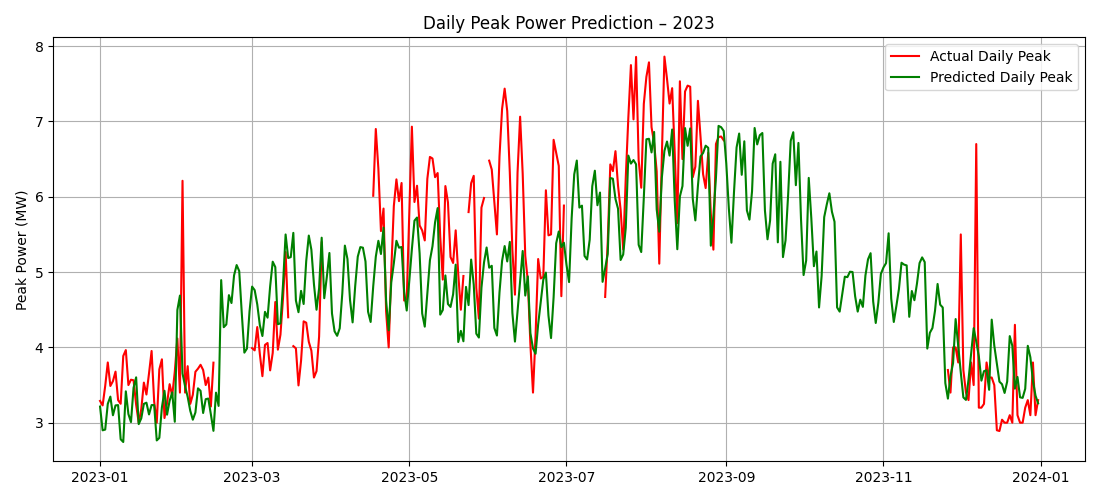

In [24]:
plt.figure(figsize=(11,5))
plt.plot(daily_demand_df_2023.index, daily_demand_df_2023["PeakPower"], label="Actual Daily Peak", color="red")
plt.plot(daily_demand_df_2023.index, daily_demand_df_2023["PredictedPeakPower"], label="Predicted Daily Peak", color="green")
plt.legend()
plt.grid()
plt.ylabel("Peak Power (MW)")
plt.title("Daily Peak Power Prediction – 2023")
plt.tight_layout()
plt.show()


In [25]:
print("Actual Peak Power for 2023 = ", daily_demand_df_2023.max().PeakPower, "\nPredicted Peak Power for 2023 = ", daily_demand_df_2023.max().PredictedPeakPower)
print("Actual Power date = ", daily_demand_df_2023.PeakPower.idxmax().date(), "\nPredicted Power date = ", daily_demand_df_2023.PredictedPeakPower.idxmax().date())

Actual Peak Power for 2023 =  7.8610411 
Predicted Peak Power for 2023 =  6.941085826783766
Actual Power date =  2023-08-08 
Predicted Power date =  2023-08-29


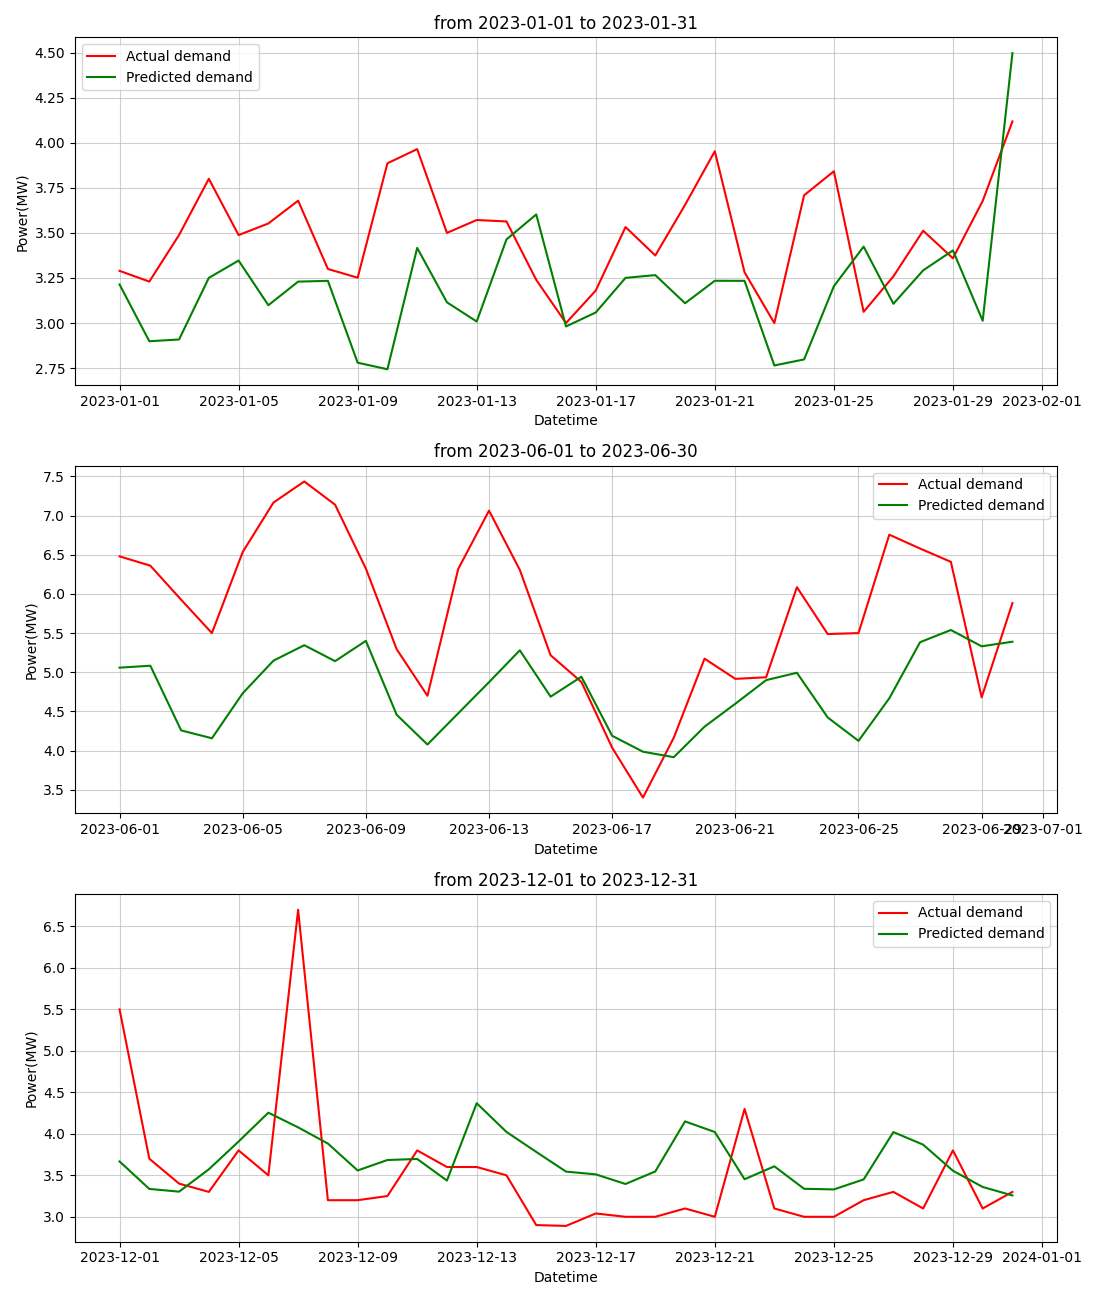

In [26]:
fig, axes = plt.subplots(3,1, figsize=(11, 13), sharex=False)
ax1, ax2, ax3 = axes.flatten()

strt1 = "2023-01-01"
end1 = "2023-01-31"
strt2 = "2023-06-01"
end2 = "2023-06-30"
strt3 = "2023-12-01"
end3 = "2023-12-31"

ax1.plot(
    daily_demand_df_2023.loc[strt1:end1].index,
    daily_demand_df_2023.loc[strt1:end1, "PeakPower"],
    label="Actual demand",
    color='red')

ax1.plot(
    daily_demand_df_2023.loc[strt1:end1].index,
    daily_demand_df_2023.loc[strt1:end1, "PredictedPeakPower"],
    label="Predicted demand",
    color='green'
)
ax1.set_xlabel("Datetime")
ax1.set_ylabel("Power(MW)")
ax1.legend()
ax1.set_title(f"from {strt1} to {end1}")
ax1.grid(alpha = 0.6)

ax2.plot(
    daily_demand_df_2023.loc[strt2:end2].index,
    daily_demand_df_2023.loc[strt2:end2, "PeakPower"],
    label="Actual demand",
    color='red')

ax2.plot(
    daily_demand_df_2023.loc[strt2:end2].index,
    daily_demand_df_2023.loc[strt2:end2, "PredictedPeakPower"],
    label="Predicted demand",
    color='green'
)
ax2.set_xlabel("Datetime")
ax2.set_ylabel("Power(MW)")
ax2.legend()
ax2.grid(alpha = 0.6)
ax2.set_title(f"from {strt2} to {end2}")


ax3.plot(
    daily_demand_df_2023.loc[strt3:end3].index,
    daily_demand_df_2023.loc[strt3:end3, "PeakPower"],
    label="Actual demand",
    color='red')

ax3.plot(
    daily_demand_df_2023.loc[strt3:end3].index,
    daily_demand_df_2023.loc[strt3:end3, "PredictedPeakPower"],
    label="Predicted demand",
    color='green'
)
ax3.set_xlabel("Datetime")
ax3.set_ylabel("Power(MW)")
ax3.legend()
ax3.set_title(f"from {strt3} to {end3}")
ax3.grid(alpha = 0.6)


plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import mean_absolute_error

mask_2023 = daily_demand_df_2023["PeakPower"].notna() & daily_demand_df_2023["PredictedPeakPower"].notna()

y_true_2023 = daily_demand_df_2023.loc[mask_2023, "PeakPower"].values
y_pred_2023 = daily_demand_df_2023.loc[mask_2023, "PredictedPeakPower"].values

mae_2023_model3 = mean_absolute_error(y_true_2023, y_pred_2023)
print("Model 3 — MAE for 2023 (Daily Peak):", mae_2023_model3, "MW")


Model 3 — MAE for 2023 (Daily Peak): 0.6612042021368169 MW


In [28]:
mask_2023_m3 = (
    daily_demand_df_2023["PeakPower"].notna() &
    daily_demand_df_2023["PredictedPeakPower"].notna() &
    (daily_demand_df_2023["PeakPower"] > 0)
)

y_true_2023_m3 = daily_demand_df_2023.loc[mask_2023_m3, "PeakPower"].values
y_pred_2023_m3 = daily_demand_df_2023.loc[mask_2023_m3, "PredictedPeakPower"].values

mape_2023_model3 = np.mean(np.abs((y_true_2023_m3 - y_pred_2023_m3) / y_true_2023_m3)) * 100
print("Model 3 — MAPE for 2023:", round(mape_2023_model3, 2), "%")

Model 3 — MAPE for 2023: 13.26 %
